In [6]:
import os 
import torch
import numpy as np
import torch
import torch.optim as optim
import random
import json
import time
from torch.utils.data import DataLoader
from celebA import CelebA

from torch.utils.data import DataLoader
#from tensorboard_logging import Logger 
#import progressbar

from model import Encoder, Decoder, Classifier
from model_loss import diff_loss, recon_loss, classify_loss
from opts import parse_opts
from torchvision import transforms
import matplotlib.pyplot as plt

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def bar(current, total, prefix="", suffix="", bar_sz=25, end_string=None):
    sp = ""
    print("\x1b[2K\r", end='')
    for i in range(bar_sz):
        if current * bar_sz // total > i:
            sp += '='
        elif current * bar_sz // total == i:
            sp += '>'
        else:
            sp += ' '
    if current == total:
        if end_string is None:
            print("\r%s[%s]%s" % (prefix, sp, suffix))
        else:
            if end_string != "":
                print("\r%s" % end_string)
            else:
                print("\r", end='')
    else:
        print("\r%s[%s]%s" % (prefix, sp, suffix), end='')
    
def psnr(outputs, targets):
    # [batch, channel, width, height]
    num_pixels = outputs.shape[2] * outputs.shape[3]
    batch_size = outputs.shape[0]
    seq_length = outputs.shape[1]
    psnr = torch.zeros((outputs.shape[0],outputs.shape[1]))
    for i in range(batch_size):
            mse = torch.mean((outputs[i,:,:,:] - targets[i,:,:,:])**2)
            psnr[i] = 20 * torch.log10(torch.max(outputs[i,:,:,:])) - 10 * torch.log10(mse)
    return torch.mean(psnr)

# show image
def imshow(tensor, title=None):
            unloader = transforms.ToPILImage() 
            image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
            image = image.squeeze(0)  # remove the fake batch dimension
            image = unloader(image)
            plt.figure()
            plt.imshow(image)
            print('show img...')
            if title is not None:
                plt.title(title)  
                
if __name__ == '__main__':
    json_path='data/annotation.json'
    att_num=6
#     json_path='data/annotation_full.json'
    args={'ann_file':json_path,'image_dir':'./data/img_align_celeba','batch_size':64,}
#     args = parse_opts()
    # Clean the directory
#     if args.clean:
#         for f in ['model.pth', 'train.log', 'val.log', 'log/']:
#             try:
#                 os.remove(os.path.join(args.save, f))
#             except:
#                 continue

#     # Check if directory exists and create one if it doesn't:
#     if not os.path.isdir(args.save):
#         os.makedirs(args.save)
        
#     log_path = os.path.join(args.save,'log')
#     if not os.path.isdir(log_path):
#         os.makedirs(log_path)

    # Create logger
    #logger = Logger(log_path)
    
    #split training and validation dataset
    pair_path='data/select_data.json'
#     pair_path='data/select_data_full.json'
    pair_list = json.load(open(pair_path,'r'))
    random.shuffle(pair_list)
    train_index_list = pair_list[:400000]
    eval_index_list = pair_list[400000:]
#     train_index_list = pair_list[:10000]
#     eval_index_list = pair_list[10000:12000]
    
    transform_train = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()])
    transform_val = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()])
    
    train_dataset = CelebA(args['ann_file'], args['image_dir'], train_index_list, transform_train, transform_train, att_num=att_num)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'], num_workers=16)
    val_dataset = CelebA(args['ann_file'], args['image_dir'], eval_index_list, transform_val, transform_val, att_num=att_num)
    val_loader = DataLoader(val_dataset, shuffle=True, batch_size=args['batch_size'], num_workers=16)

#     print("| Data Loaded: # training data: %d, # val data: %d" % (len(train_loader)* args['batch_size'], len(val_loader) * args['batch_size']))

    ###############################################################################
    # Build the model
    ###############################################################################
    encoder = Encoder()
    decoder = Decoder(att_num=att_num)
    classifier = Classifier(att_num)

    encoder.cuda()
    decoder.cuda()
    classifier.cuda()
    ###############################################################################
    # Resume model
    ###############################################################################
#     cp_path='../TrainWithFrozenClassifier2/checkpoint_1.pth'
    cp_path='../results/checkpoint_3-Copy1.pth'
    if cp_path:
        print('loading checkpoint {}'.format(cp_path))
        checkpoint = torch.load(cp_path)
#         args.start_epoch = checkpoint['epoch']
        encoder.load_state_dict(checkpoint['encoder'])
        decoder.load_state_dict(checkpoint['decoder'])
        classifier.load_state_dict(checkpoint['classifier'])
   

    ###############################################################################
    # Visiualization
    ###############################################################################
    loss_z_val = AverageMeter()
    loss_recon_val = AverageMeter()
    loss_classify_val = AverageMeter()
    loss_val = AverageMeter()
    psnr_val = AverageMeter()
    encoder.eval()
    decoder.eval()
    classifier.eval()
    for batch_idx, data in enumerate(val_loader):
        # test : just run one batch
        if batch_idx>0:
            break
        batch_start_time = time.time()
        img_1 = data[0].cuda()
        img_2 = data[1].cuda()
        img_1_atts = data[2].cuda()
        img_2_atts = data[3].cuda() 

        z_1 = encoder(img_1)
        z_2 = encoder(img_2)
        img_2_trans = decoder(z_1, img_2_atts)
        img_1_trans = decoder(z_2, img_1_atts)
        img_1_recon = decoder(z_1, img_1_atts)
        img_2_recon = decoder(z_2, img_2_atts)
        img_1_atts_pre = classifier(img_1_trans)
        img_2_atts_pre = classifier(img_2_trans)
        print('done!')
        # show and save images        
        img_save_path='./Reconstruction images'

loading checkpoint ../results/checkpoint_3-Copy1.pth
done!


show img...
show img...
show img...
show img...


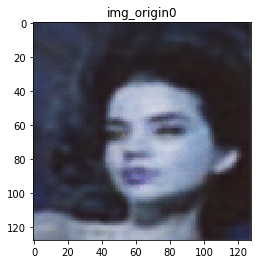

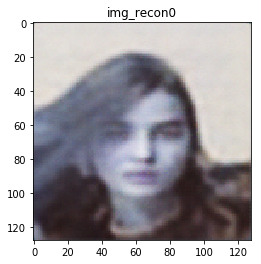

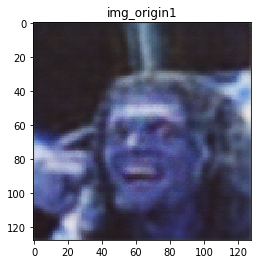

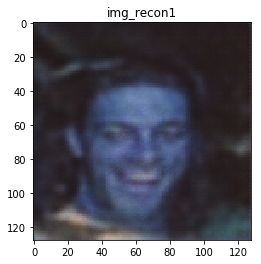

In [9]:
img_1_recon.shape
for i in range(img_1_recon.shape[0]):
         # test : just show one image
        if i>1:
            break
        img_name_origin='img_origin'+str(i)
        img_name_recon='img_recon'+str(i)            
        imshow(img_1_recon[i], title=img_name_origin)
        imshow(img_2_recon[i], title=img_name_recon)

show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...


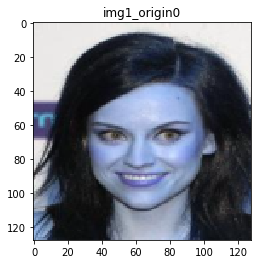

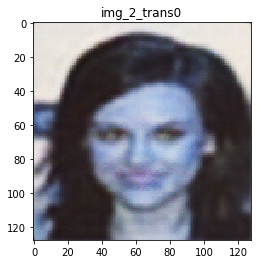

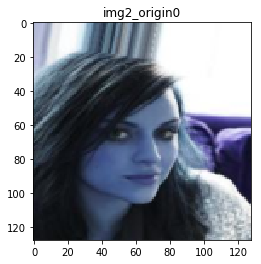

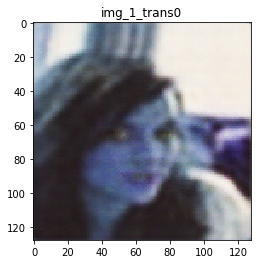

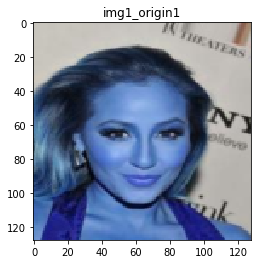

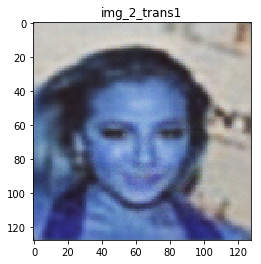

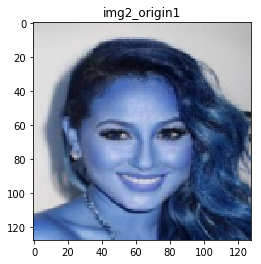

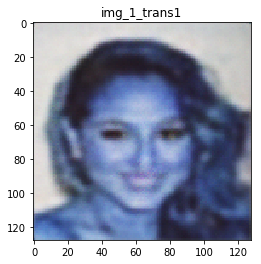

In [15]:
for i in range(img_1_recon.shape[0]):
         # test : just show one image
        if i>1:
            break
        img1_name_origin='img1_origin'+str(i)
        img1_name_trans='img_1_trans'+str(i)
        img2_name_origin='img2_origin'+str(i)
        img2_name_trans='img_2_trans'+str(i)        
        imshow(img_1[i], title=img1_name_origin)
        imshow(img_2_trans[i], title=img2_name_trans)
        imshow(img_2[i], title=img2_name_origin)
        imshow(img_1_trans[i], title=img1_name_trans)
       

In [22]:

        for i in range(img_1_recon.shape[0]):
             # test : just show one image
            if i>0:
                break
            img_name_origin='img_origin'+str(i)
            img_name_recon='img_recon'+str(i)            
            imshow(img_1_recon[i], title=img_name_origin)
            imshow(img_2_recon[i], title=img_name_recon)

        loss_z_cur = diff_loss(z_1, z_2)
        loss_recon_cur = recon_loss(img_1_recon, img_1) +  recon_loss(img_2_recon, img_2)
        loss_classify_cur = classify_loss(img_1_atts_pre, img_1_atts) + classify_loss(img_2_atts_pre, img_2_atts)           

        loss_cur = loss_z_cur + 1 * loss_recon_cur + 0.1 * loss_classify_cur
        psnr_cur = psnr(img_1_recon, img_1) + psnr(img_2_recon, img_2)
        psnr_val.update(psnr_cur)


        loss_z_val.update(loss_z_cur.item())
        loss_recon_val.update(loss_recon_cur.item())
        loss_classify_val.update(loss_classify_cur.item())
        loss_val.update(loss_cur.item())
        batch_time = time.time() - batch_start_time         
#         bar(batch_idx, "Epoch: {:3d} | ".format(0),
#         ' | time {:.3f} | loss_val {:.5f} | loss_z_val {:.5f} | loss_recon_val {:.5f} | loss_classify_val {:.5f}  |'.format(
#             batch_time, loss_val.val, loss_z_val.val, loss_recon_val.val, loss_classify_val.val), end_string="")

#     log_entry_val = '\n| end of epoch {:3d} | time: {:5.5f}s | valid loss {:.5f} | valid recon loss {:.5f} | valid classify loss {:.5f} | valid psnr {:5.2f}'.format(
#         0, (time.time() - epoch_start_time),loss_val.avg, loss_recon_val.avg, loss_classify_val.avg, psnr_val.avg)
#     print(log_entry_val)       

torch.Size([64, 6])
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...
show img...


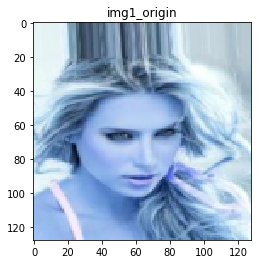

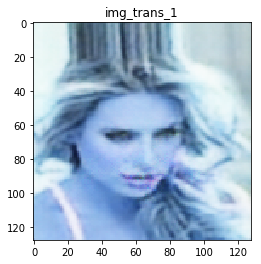

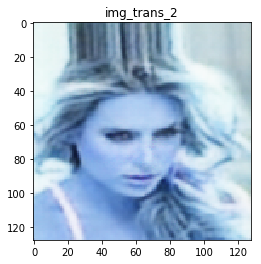

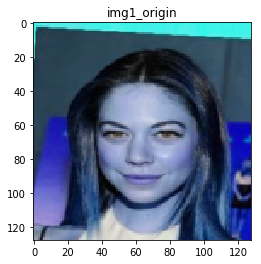

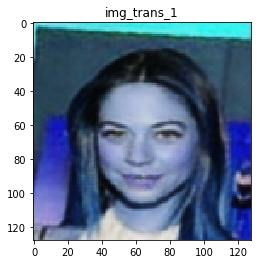

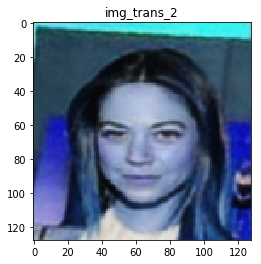

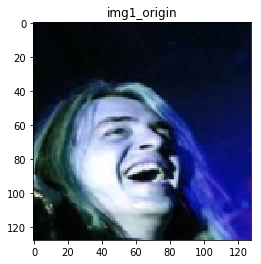

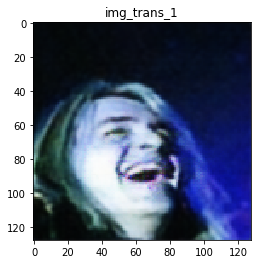

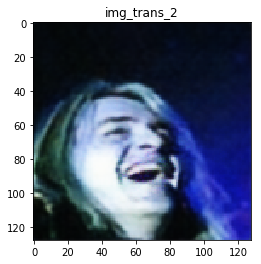

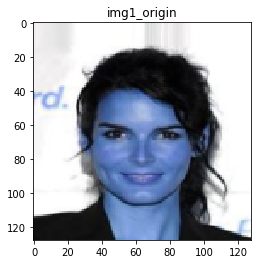

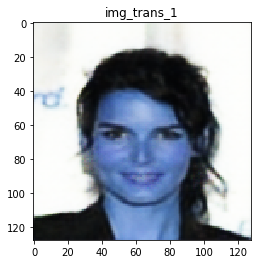

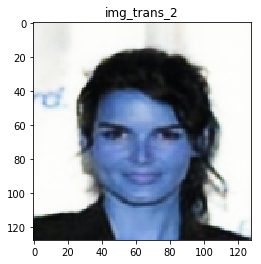

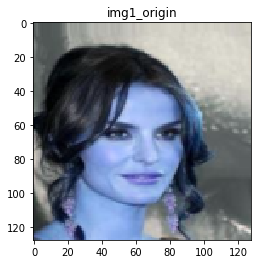

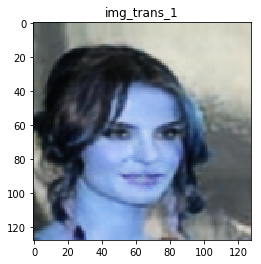

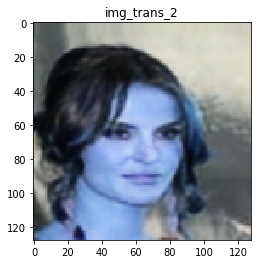

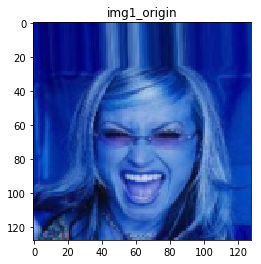

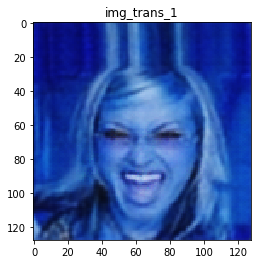

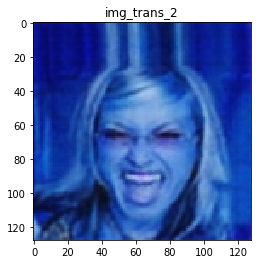

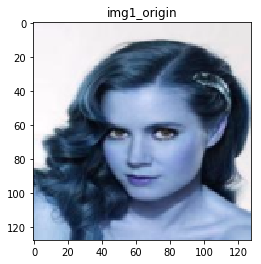

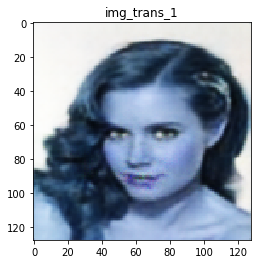

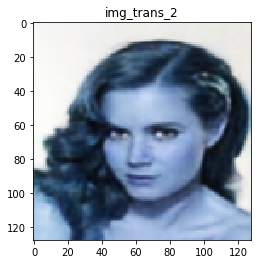

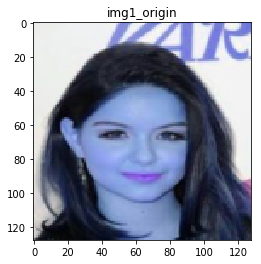

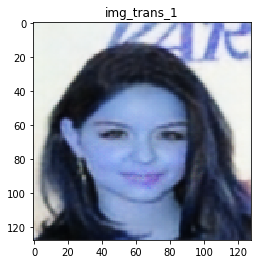

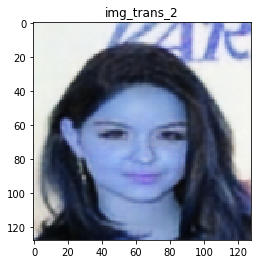

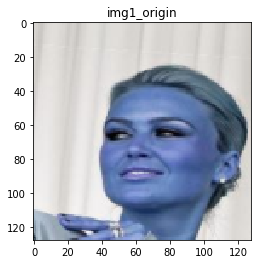

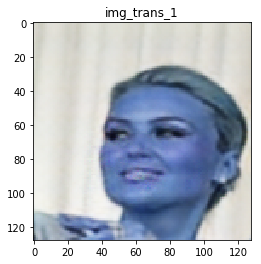

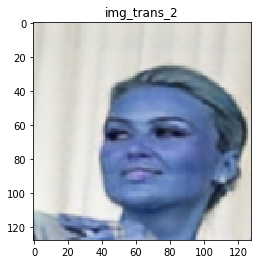

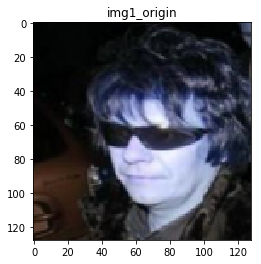

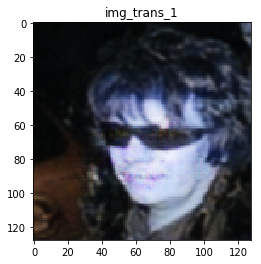

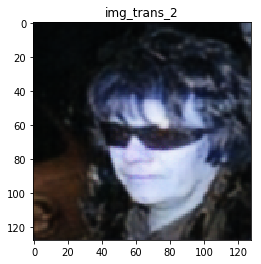

In [7]:
# change sttributes
atts1=torch.tensor([[1.0]*att_num]*64)
atts2=torch.tensor([[0.0]*att_num]*64)
print(atts1.shape)
atts1 = atts1.cuda()
atts2 = atts2.cuda() 
for batch_idx, data in enumerate(val_loader):
    # test : just run one batch
    if batch_idx>0:
        break
    batch_start_time = time.time()
    img_1 = data[0].cuda()
# img_1=val_loader[0][0]
z_1 = encoder(img_1)
# z_2 = encoder(img_2)
img_trans_attr1 = decoder(z_1, atts1)
img_trans_attr2 = decoder(z_1, atts2)
img1_name_origin='img1_origin'
img1_name_trans1='img_trans_1'
img1_name_trans2='img_trans_2'
# show the n-th image
for n in range(10):
#     n=2
    imshow(img_1[n], title=img1_name_origin)
    imshow(img_trans_attr1[n], title=img1_name_trans1)
    imshow(img_trans_attr2[n], title=img1_name_trans2)


In [25]:
img_1_atts

tensor([[1., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1.],
        [1., 0